In [1]:
from datasets import load_dataset

dataset = load_dataset("ryo0634/bsd_ja_en")

In [15]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tag', 'title', 'original_language', 'no', 'en_speaker', 'ja_speaker', 'en_sentence', 'ja_sentence'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['id', 'tag', 'title', 'original_language', 'no', 'en_speaker', 'ja_speaker', 'en_sentence', 'ja_sentence'],
        num_rows: 2120
    })
    validation: Dataset({
        features: ['id', 'tag', 'title', 'original_language', 'no', 'en_speaker', 'ja_speaker', 'en_sentence', 'ja_sentence'],
        num_rows: 2051
    })
})

In [16]:
dataset["train"][0]

{'id': '190329_J07_03',
 'tag': 'phone call',
 'title': '伝言への折り返し電話\u3000打ち合わせ日程調整',
 'original_language': 'ja',
 'no': 1,
 'en_speaker': 'Doi-san',
 'ja_speaker': '土井さん',
 'en_sentence': 'Hi this is the systems development department of Company K.',
 'ja_sentence': 'はい、K社システム開発部です。'}

In [2]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_name = "Helsinki-NLP/opus-mt-ja-en"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

source.spm:   0%|          | 0.00/782k [00:00<?, ?B/s]

c:\Users\Shen\miniconda3\envs\sklearn-env\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Shen\.cache\huggingface\hub\models--Helsinki-NLP--opus-mt-ja-en. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

c:\Users\Shen\miniconda3\envs\sklearn-env\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/303M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [ ]:
import torch

# check if a GPU is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [4]:
model = model.to(device)

In [5]:
def translate_conversations(example):
    ja_sentence = example["ja_sentence"]
    
    inputs = tokenizer(ja_sentence, return_tensors="pt", truncation=True).to(device)
    
    outputs = model.generate(**inputs)
    
    translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    example["translated_en_sentence"] = translated_text
    return example


In [6]:
translated_dataset = dataset.map(translate_conversations)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2120 [00:00<?, ? examples/s]

Map:   0%|          | 0/2051 [00:00<?, ? examples/s]

In [9]:
from sacrebleu import corpus_bleu

tags = set(example["tag"] for example in dataset["train"])
blue_score_by_tag = {}

for tag in tags:
    subset = translated_dataset["train"].filter(lambda example: example["tag"] == tag)
    
    references = [example["en_sentence"] for example in subset]
    predictions = [example["translated_en_sentence"] for example in subset]
    
    bleu = corpus_bleu(predictions, [references])
    blue_score_by_tag[tag] = bleu.score

blue_score_by_tag

Filter:   0%|          | 0/20000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/20000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/20000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/20000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/20000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/20000 [00:00<?, ? examples/s]

{'general chatting': 18.284556260942917,
 'meeting': 15.666528722573773,
 'training': 14.895802791949997,
 'phone call': 17.434565771586673,
 'face-to-face conversation': 16.73023288720671,
 'presentation': 17.739641831029484}

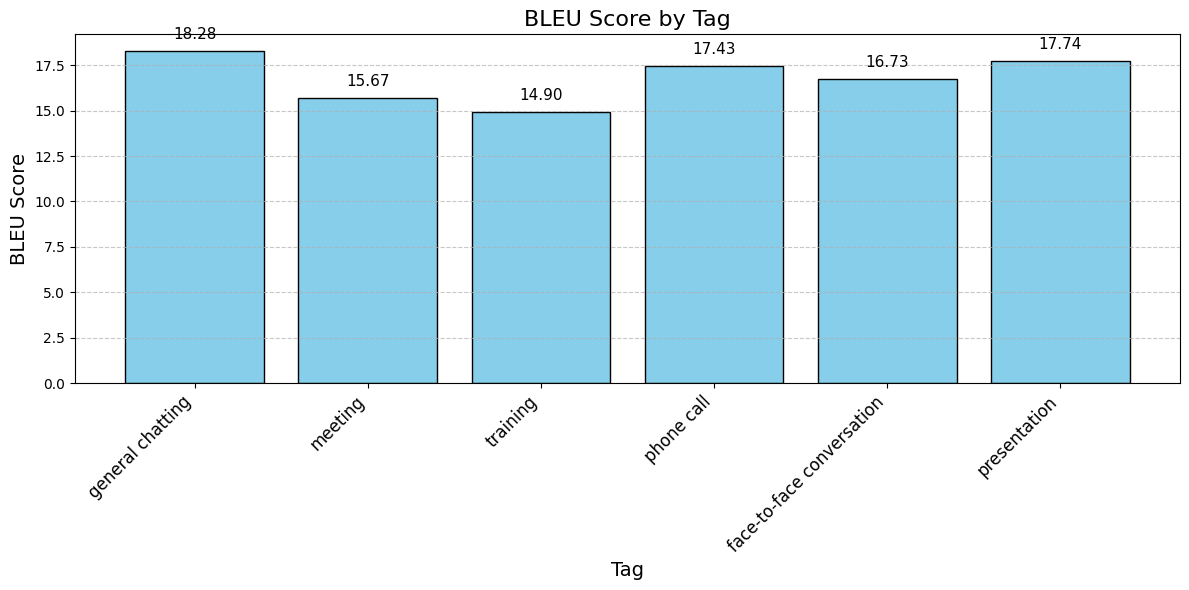

In [13]:
import matplotlib.pyplot as plt

# plt.style.use("seaborn-darkgrid")
plt.figure(figsize=(12, 6), dpi=100)

bars = plt.bar(blue_score_by_tag.keys(), blue_score_by_tag.values(), color="skyblue", edgecolor="black")

plt.ylabel("BLEU Score", fontsize=14)
plt.xlabel("Tag", fontsize=14)
plt.title("BLEU Score by Tag", fontsize=16)

plt.xticks(rotation=45, ha="right", fontsize=12)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f"{yval:.2f}", ha="center", va="bottom", fontsize=11, color="black")

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


We can find that General chatting BLEU scores the highest because Japanese expressions in informal situations are closer to English.

BLEU scores gradually decreased as the scenes became more formal, as many formal forms of expression in Japanese could not be translated into English.

In [15]:
blue_score_by_origin = {}

for origin in ["ja", "en"]:
    subset = translated_dataset["train"].filter(lambda example: example["original_language"] == origin)
    
    references = [example["en_sentence"] for example in subset]
    predictions = [example["translated_en_sentence"] for example in subset]
    
    bleu = corpus_bleu(predictions, [references])
    blue_score_by_origin[origin] = bleu.score

blue_score_by_origin

Filter:   0%|          | 0/20000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/20000 [00:00<?, ? examples/s]

{'ja': 13.945030013656764, 'en': 20.24684987288961}

Similarly, sentences where the original text is in English have higher BLEU scores because they are closer to the translation.

In [16]:
references = [example["en_sentence"] for example in translated_dataset["train"]]
predictions = [example["translated_en_sentence"] for example in translated_dataset["train"]]
bleu = corpus_bleu(predictions, [references])
bleu.score

16.858457603256294

In [22]:
# sous corpus long
subset = translated_dataset["train"].filter(lambda example: len(tokenizer(example["ja_sentence"])["input_ids"]) > 20 )

references = [example["en_sentence"] for example in subset]
predictions = [example["translated_en_sentence"] for example in subset]

bleu = corpus_bleu(predictions, [references])
bleu.score

Filter:   0%|          | 0/20000 [00:00<?, ? examples/s]

14.871707409802534

We used the "gestion des séquences longues" technique we learned in class to select sentences longer than third quartile and recalculated the BLEU scores, and found that the BLEU scores decreased due to the increased difficulty of translating longer sentences.